
## setup


In [1]:
from IPython.display import display
import pandas as pd 
import pickle
import os 
from utils.env import EvoD4jEnv
import re 

project = "Lang"
ts_id = "newTS"
prompt_no = 3
example_num = 2

In [2]:
def get_passing_ground_truth(project, ts_id, evo_tests_df_all):
    for i in range(1, 66):
        if i == 2 or i == 30 or i == 63:
            evo_tests_df_all.append(pd.DataFrame())
            continue # deprecated version
        env = EvoD4jEnv(project, i, ts_id)
        evo_test_path = env.evosuite_test_dir.replace("/root/workspace","/Users/hslee/Workspace/AutoOracle/workspace")
        with open(os.path.join(evo_test_path, "evo_tests_df.pkl"),'rb') as f:
            evo_tests_df = pickle.load(f)
            evo_tests_df["ground_truth"] = "correct"
            evo_tests_df["ground_truth_mut"] = "incorrect"
        evo_tests_df_all.append(evo_tests_df)
    return evo_tests_df_all

In [3]:
def get_failing_ground_truth(project, ts_id, evo_tests_df_all):
    for i in range(1, 66):
        if i == 2 or i == 30 or i == 63:
            continue # deprecated version
        env = EvoD4jEnv(project, i, ts_id)
        evo_test_path = env.evosuite_test_dir.replace("/root/workspace","/Users/hslee/Workspace/AutoOracle/workspace")
        # Filtering the failing tests
        with open(os.path.join(evo_test_path, "failing_tests_on_fixed")) as f:
            data = f.readlines()
        for l in data:
            if l.startswith('---'):
                pattern = r"--- (.*?)::(.*?)$"
                match = re.search(pattern, l)
                if match:
                    class_name = match.group(1)
                    class_name = class_name.replace('.', '/')+'.java'
                    test_no = match.group(2)
                evo_tests_df = evo_tests_df_all[i]
                evo_tests_df.loc[(evo_tests_df["evo_relpath"] == class_name) & (evo_tests_df["evo_test_no"] == test_no),"ground_truth"] = "incorrect"
                evo_tests_df.loc[(evo_tests_df["evo_relpath"] == class_name) & (evo_tests_df["evo_test_no"] == test_no),"ground_truth_mut"] = "correct"
    return evo_tests_df_all

In [17]:
def parsing_chat_reply(project, ts_id, evo_tests_df_all):
    # Parsing Chat_reply with prompt 1 
    for i in range(1, 66):
        if i == 2 or i==30 or i == 63 :
            continue # deprecated version or compilation error
        env = EvoD4jEnv(project, i, ts_id)
        chat_reply_dir_root = env.evosuite_chat_reply_dir.replace("/root/workspace","/Users/hslee/Workspace/AutoOracle/workspace")

        #with prompt{prompt_no} & example{example_num}
        for j in range(1,4):
            chat_reply_dir = os.path.join(chat_reply_dir_root,"prompt{}/example{}/try{}".format(prompt_no, example_num, j))
            chat_reply_list = os.listdir(chat_reply_dir)
            for chat_reply_f in chat_reply_list:
                if chat_reply_f.endswith("gpt4"):
                    with open(os.path.join(chat_reply_dir, chat_reply_f),'r') as fr:
                        data = fr.read()
                    split_chat_reply_f = chat_reply_f.strip().split('_')
                    dir = split_chat_reply_f[0].replace('.','/')
                    test_no = split_chat_reply_f[1]
                    df = evo_tests_df_all[i]
                    if re.search("<correct>", data):
                        df.loc[ (df["dir"] == dir) & (df["evo_test_no"] == test_no), "predict{}".format(j) ] = "correct" 
                    elif re.search("<incorrect>", data):
                        df.loc[ (df["dir"] == dir) & (df["evo_test_no"] == test_no), "predict{}".format(j) ] = "incorrect"
    return evo_tests_df_all
                

In [14]:
def parsing_chat_reply_mut(project, ts_id, evo_tests_df_all):
    # Parsing chat_reply_mut with prompt
    for i in range(1, 66):
        if i == 2 or i==30 or i == 63 :
            continue # deprecated version or compilation error
        env = EvoD4jEnv(project, i, ts_id)
        chat_reply_mut_dir_root = env.evosuite_chat_reply_mut_dir.replace("/root/workspace","/Users/hslee/Workspace/AutoOracle/workspace")

        #with prompt{prompt_no} & example{example_num}
        for j in range(1,4):
            chat_reply_dir = os.path.join(chat_reply_mut_dir_root,"prompt{}/example2/try{}".format(prompt_no, example_num, j))
            chat_reply_list = os.listdir(chat_reply_dir)
            for chat_reply_f in chat_reply_list:
                if chat_reply_f.endswith("gpt4"):
                    print('hi')
                    with open(os.path.join(chat_reply_dir, chat_reply_f),'r') as fr:
                        data = fr.read()
                    split_chat_reply_f = chat_reply_f.strip().split('_')
                    dir = split_chat_reply_f[0].replace('.','/')
                    test_no = split_chat_reply_f[1]
                    df = evo_tests_df_all[i]
                    if re.search("<correct>", data):
                        df.loc[ (df["dir"] == dir) & (df["evo_test_no"] == test_no), "predict_mut{}".format(j)  ] = "correct" 
                    elif re.search("<incorrect>", data):
                        df.loc[ (df["dir"] == dir) & (df["evo_test_no"] == test_no), "predict_mut{}".format(j) ] = "incorrect"
    return evo_tests_df_all



In [18]:
evo_tests_df_all = [] 
evo_tests_df_all.append(pd.DataFrame())

evo_tests_df_all = get_passing_ground_truth(project, ts_id, evo_tests_df_all)
evo_tests_df_all = get_failing_ground_truth(project, ts_id, evo_tests_df_all)
evo_tests_df_all = parsing_chat_reply(project, ts_id, evo_tests_df_all)
#evo_tests_df_all = parsing_chat_reply_mut(project, ts_id, evo_tests_df_all)

evo_tests_df_all[1]


,dir,evo_relpath,evo_test_no,evo_test_src,evo_target_method,evo_embedding,ground_truth,ground_truth_mut,predict1
0,org/apache/commons/lang3,org/apache/commons/lang3/StringUtils_ESTest.java,test0,@Test(timeout = 4000)\n public void test0() ...,[org.apache.commons.lang3.StringUtils.<init>()V],"[0.06976258, 0.06450689, -0.049689177, 0.03320...",correct,incorrect,NaN
0,org/apache/commons/lang3,org/apache/commons/lang3/StringUtils_ESTest.java,test1,@Test(timeout = 4000)\n public void test1() ...,[org.apache.commons.lang3.StringUtils.isBlank(...,"[0.0857531, 0.023650946, -0.08351751, 0.010157...",correct,incorrect,correct
0,org/apache/commons/lang3,org/apache/commons/lang3/StringUtils_ESTest.java,test2,@Test(timeout = 4000)\n public void test2() ...,[org.apache.commons.lang3.StringUtils.isBlank(...,"[0.12033633, 0.049902406, -0.066007264, 0.0241...",correct,incorrect,correct
0,org/apache/commons/lang3,org/apache/commons/lang3/StringUtils_ESTest.java,test3,@Test(timeout = 4000)\n public void test3() ...,[org.apache.commons.lang3.StringUtils.isBlank(...,"[0.08782237, 0.04695323, -0.07713577, 0.015571...",correct,incorrect,correct
0,org/apache/commons/lang3/math,org/apache/commons/lang3/math/NumberUtils_ESTe...,test0,@Test(timeout = 4000)\n public void test00() ...,[org.apache.commons.lang3.math.NumberUtils.cre...,"[0.088193454, 0.04130702, -0.08280655, -0.0242...",correct,incorrect,incorrect
0,org/apache/commons/lang3/math,org/apache/commons/lang3/math/NumberUtils_ESTe...,test1,@Test(timeout = 4000)\n public void test01() ...,[org.apache.commons.lang3.math.NumberUtils.cre...,"[0.079090714, 0.05323288, -0.0412874, -0.02717...",correct,incorrect,incorrect
0,org/apache/commons/lang3/math,org/apache/commons/lang3/math/NumberUtils_ESTe...,test2,@Test(timeout = 4000)\n public void test02() ...,[org.apache.commons.lang3.math.NumberUtils.cre...,"[0.055880647, 0.0015647653, -0.054296162, -0.0...",correct,incorrect,incorrect
0,org/apache/commons/lang3/math,org/apache/commons/lang3/math/NumberUtils_ESTe...,test3,@Test(timeout = 4000)\n public void test03() ...,[org.apache.commons.lang3.math.NumberUtils.cre...,"[0.074620865, 0.009687895, -0.06447109, -0.068...",correct,incorrect,incorrect
0,org/apache/commons/lang3/math,org/apache/commons/lang3/math/NumberUtils_ESTe...,test4,@Test(timeout = 4000)\n public void test04() ...,[org.apache.commons.lang3.math.NumberUtils.cre...,"[0.095152274, 0.022659494, -0.081911266, -0.02...",correct,incorrect,incorrect
0,org/apache/commons/lang3/math,org/apache/commons/lang3/math/NumberUtils_ESTe...,test5,@Test(timeout = 4000)\n public void test05() ...,[org.apache.commons.lang3.math.NumberUtils.cre...,"[0.08212308, 0.08638666, -0.06136275, -0.00738...",correct,incorrect,correct


In [9]:
from sklearn import metrics

column = ["dir", "evo_test_no", "ground_truth", "predict1", "predict2", "predict3", "ground_truth_mut", "predict_mut1", "predict_mut2", "predict_mut3"] 

all_df = pd.DataFrame(columns = column)
for i in range(1, 66):
    if i == 2 or i==30 or i == 63 :
        continue # deprecated version or compilation error
    
    if 'predict_mut1' in evo_tests_df_all[i].columns and 'predict1' in evo_tests_df_all[i].columns:
        evo_tests_df_all[i] = evo_tests_df_all[i][column]
        evo_tests_df_all[i]["Predict"] = 0
        for j in range(1,4):
            evo_tests_df_all[i].loc[evo_tests_df_all[i]["predict{}".format(j)] == "correct", "Predict"] += 1
            evo_tests_df_all[i].loc[evo_tests_df_all[i]["predict{}".format(j)] == "incorrect", "Predict"] -= 1
            evo_tests_df_all[i].loc[evo_tests_df_all[i]["predict_mut{}".format(j)] == "correct", "Predict"] -= 1
            evo_tests_df_all[i].loc[evo_tests_df_all[i]["predict_mut{}".format(j)]  == "incorrect", "Predict"] += 1
            evo_tests_df_all[i]["version"] = i
        all_df = pd.concat([all_df, evo_tests_df_all[i]])


all_df= all_df.dropna(axis=0)
all_df.head()


,dir,evo_test_no,ground_truth,predict1,predict2,predict3,ground_truth_mut,predict_mut1,predict_mut2,predict_mut3


ValueError: Could not interpret value `Predict` for `x`. An entry with this name does not appear in `data`.

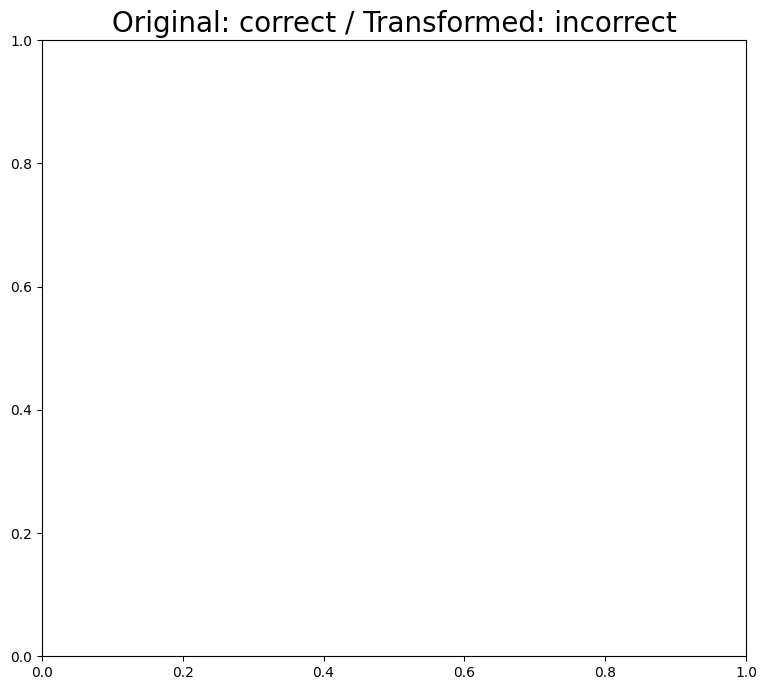

In [8]:
import matplotlib.pyplot as plt
from IPython.display import Image
from collections import Counter
import seaborn as sns


passing_data = all_df[all_df["ground_truth"]=="correct"]
failing_data = all_df[all_df["ground_truth"]=="incorrect"]

plt.figure(figsize=(20, 8))

# passing_score = passing_data["score"].value_counts()
# failing_score = passing_data["score"].value_counts()
plt.subplot(1,2,1)
plt.title("Original: correct / Transformed: incorrect", fontdict = {'fontsize' : 20})
a= sns.countplot(passing_data, x="Predict", color='#4BC6CC')
for p in a.patches:
    height = p.get_height()
    a.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 12)
a.set_xlabel("Predict", fontsize = 20)
a.set_ylabel("number of test", fontsize = 20)

plt.subplot(1,2,2)
plt.title("Original: incorrect / Transformed: correct", fontdict = {'fontsize' : 20})
b= sns.countplot(failing_data, x="Predict", color='#FF6E3E')
for p in b.patches:
    height = p.get_height()
    b.text(p.get_x() + p.get_width() / 2., height + 0.1, height, ha = 'center', size = 12)
b.set_xlabel("Predict", fontsize = 20)
b.set_ylabel("number of test", fontsize = 20)

plt.show()


In [ ]:
display(failing_data)

,dir,evo_test_no,ground_truth,predict1,predict2,predict3,ground_truth_mut,predict_mut1,predict_mut2,predict_mut3,Predict,version
0,org/apache/commons/lang3/math,test33,incorrect,incorrect,incorrect,incorrect,correct,correct,correct,correct,-6.0,7.0
0,org/apache/commons/lang3/time,test3,incorrect,incorrect,correct,correct,correct,incorrect,incorrect,incorrect,4.0,9.0
0,org/apache/commons/lang3/time,test12,incorrect,correct,correct,correct,correct,correct,correct,correct,0.0,9.0
0,org/apache/commons/lang3/time,test14,incorrect,correct,correct,correct,correct,incorrect,incorrect,incorrect,6.0,9.0
0,org/apache/commons/lang3/time,test17,incorrect,incorrect,correct,correct,correct,incorrect,incorrect,incorrect,4.0,9.0
0,org/apache/commons/lang3/time,test18,incorrect,correct,incorrect,incorrect,correct,incorrect,incorrect,incorrect,2.0,9.0
0,org/apache/commons/lang3/time,test19,incorrect,incorrect,incorrect,correct,correct,incorrect,incorrect,incorrect,2.0,9.0
0,org/apache/commons/lang3/time,test11,incorrect,correct,correct,correct,correct,correct,correct,correct,0.0,10.0
0,org/apache/commons/lang3,test13,incorrect,incorrect,correct,incorrect,correct,incorrect,incorrect,incorrect,2.0,11.0
0,org/apache/commons/lang3/time,test13,incorrect,incorrect,correct,correct,correct,incorrect,incorrect,incorrect,4.0,18.0


In [ ]:
# from sklearn import metrics

# print("*********************************")
# print("Score Graph __ Original & Mut")
# print("*********************************")

# org_ground_truth = passing["ground_truth"].values.tolist()
# mut_ground_truth = passing["ground_truth_mut"].values.tolist()
# passing_ground_truth = [ 1 if x == ("correct","incorrect") else 0 for x in zip(org_ground_truth,mut_ground_truth)]

# org_predict = passing["predict1"].values.tolist()
# mut_predict = passing["predict_mut1"].values.tolist()
# passing_predict = [ 1 if x == ("correct", "incorrect") else 0 for x in zip(org_predict, mut_predict)]
# ground_truth.extend(passing_ground_truth)
# predict.extend(passing_predict)

# #Failing test // Original: Incorrect, Mutation: Correct => 0
# failing = evo_test_df_all[i].loc[ (evo_test_df_all[i]["ground_truth"] == "incorrect") & (evo_test_df_all[i]["ground_truth_mut"]=="correct"),:]
# num_of_failing += failing.shape[0]
# all_df = pd.concat([all_df, failing])

# org_ground_truth = failing["ground_truth"].values.tolist()
# mut_ground_truth = failing["ground_truth_mut"].values.tolist()
# failing_ground_truth = [ 0 if x == ("incorrect","correct") else 1 for x in zip(org_ground_truth, mut_ground_truth)]

# org_predict = failing["predict1"].values.tolist()
# mut_predict = failing["predict_mut1"].values.tolist()
# failing_predict = [ 0 if x == ("incorrect", "correct") else 1 for x in zip(org_predict, mut_predict)]

# ground_truth.extend(failing_ground_truth)
# predict.extend(failing_predict)
# all_df.to_csv('./b.csv')
# tn, fp, fn, tp = metrics.confusion_matrix(ground_truth, predict).ravel()

# print("True Negative:", tn)
# print("False Positive:", fp)
# print("False Negative:", fn)
# print("True Positive:", tp,'\n')

# accuracy = metrics.accuracy_score(ground_truth, predict)
# print("accuracy:", accuracy)

# precision = metrics.precision_score(ground_truth, predict)
# print("precision:", precision)

# recall = metrics.recall_score(ground_truth, predict)
# print("recall:", recall)

# f1 = metrics.f1_score(ground_truth, predict)
# print("f1:", f1)

# print(tn+fp+fn+tp)

In [ ]:
# from sklearn import metrics

# column = ['dir', 'evo_test_no', "ground_truth", "predict1", "predict2", "predict3", "ground_truth_mut", "predict_mut1", "predict_mut2", "predict_mut3"] 

# all_df = pd.DataFrame(columns = column)
# for i in range(1, 66):
#     if i == 2 or i==30 or i == 63 :
#         continue # deprecated version or compilation error
    
#     if 'predict_mut{}'.format(j) in evo_test_df_all[i].columns:
#         evo_test_df_all[i] = evo_test_df_all[i][column]
#         evo_test_df_all[i] = evo_test_df_all[i].loc[evo_test_df_all[i]["predict1"] == evo_test_df_all[i]["predict2"],]
#         evo_test_df_all[i] = evo_test_df_all[i].loc[evo_test_df_all[i]["predict2"] == evo_test_df_all[i]["predict3"],:]
#         evo_test_df_all[i] = evo_test_df_all[i].loc[evo_test_df_all[i]["predict_mut1"] == evo_test_df_all[i]["predict_mut2"],:]
#         evo_test_df_all[i] = evo_test_df_all[i].loc[evo_test_df_all[i]["predict_mut2"] == evo_test_df_all[i]["predict_mut3"],:]
        
#         #Passing test // Original: Correct, Mutaion: Incorrect => 1
#         passing = evo_test_df_all[i].loc[ (evo_test_df_all[i]["ground_truth"] =="correct") & (evo_test_df_all[i]["ground_truth_mut"]=="incorrect"),:]
#         all_df = pd.concat([all_df, passing])

#         #Failing test // Original: Incorrect, Mutation: Correct => 0
#         failing = evo_test_df_all[i].loc[ (evo_test_df_all[i]["ground_truth"] == "incorrect") & (evo_test_df_all[i]["ground_truth_mut"]=="correct"),:]
#         all_df = pd.concat([all_df, failing])



# from sklearn import metrics

# print("*********************************")
# print("Consistency __ Original & Mut")
# print("*********************************")
# ground_truth =[]
# predict=[]
# num_of_passing = 0
# num_of_failing = 0

# all_df = pd.DataFrame(columns=['dir', 'evo_test_no', "ground_truth", "predict1", "predict2", "predict3", "ground_truth_mut", "predict_mut1", "predict_mut2", "predict_mut3"])
# for i in range(1, 66):
#     if i == 2 or i==30 or i == 63 :
#         continue # deprecated version or compilation error
    
#     if 'predict_mut{}'.format(j) in evo_test_df_all[i].columns:
#         evo_test_df_all[i] = evo_test_df_all[i][['dir', 'evo_test_no', "ground_truth", "predict1", "predict2", "predict3", "ground_truth_mut", "predict_mut1", "predict_mut2", "predict_mut3"]]
#         evo_test_df_all[i] = evo_test_df_all[i].loc[evo_test_df_all[i]["predict1"] == evo_test_df_all[i]["predict2"],]
#         evo_test_df_all[i] = evo_test_df_all[i].loc[evo_test_df_all[i]["predict2"] == evo_test_df_all[i]["predict3"],:]
#         evo_test_df_all[i] = evo_test_df_all[i].loc[evo_test_df_all[i]["predict_mut1"] == evo_test_df_all[i]["predict_mut2"],:]
#         evo_test_df_all[i] = evo_test_df_all[i].loc[evo_test_df_all[i]["predict_mut2"] == evo_test_df_all[i]["predict_mut3"],:]
        
#         #Passing test // Original: Correct, Mutaion: Incorrect => 1
#         passing = evo_test_df_all[i].loc[ (evo_test_df_all[i]["ground_truth"] =="correct") & (evo_test_df_all[i]["ground_truth_mut"]=="incorrect"),:]
#         num_of_passing += passing.shape[0]
#         all_df = pd.concat([all_df, passing])
#         org_ground_truth = passing["ground_truth"].values.tolist()
#         mut_ground_truth = passing["ground_truth_mut"].values.tolist()
#         passing_ground_truth = [ 1 if x == ("correct","incorrect") else 0 for x in zip(org_ground_truth,mut_ground_truth)]
        
#         org_predict = passing["predict1"].values.tolist()
#         mut_predict = passing["predict_mut1"].values.tolist()
#         passing_predict = [ 1 if x == ("correct", "incorrect") else 0 for x in zip(org_predict, mut_predict)]
#         ground_truth.extend(passing_ground_truth)
#         predict.extend(passing_predict)

#         #Failing test // Original: Incorrect, Mutation: Correct => 0
#         failing = evo_test_df_all[i].loc[ (evo_test_df_all[i]["ground_truth"] == "incorrect") & (evo_test_df_all[i]["ground_truth_mut"]=="correct"),:]
#         num_of_failing += failing.shape[0]
#         all_df = pd.concat([all_df, failing])

#         org_ground_truth = failing["ground_truth"].values.tolist()
#         mut_ground_truth = failing["ground_truth_mut"].values.tolist()
#         failing_ground_truth = [ 0 if x == ("incorrect","correct") else 1 for x in zip(org_ground_truth, mut_ground_truth)]

#         org_predict = failing["predict1"].values.tolist()
#         mut_predict = failing["predict_mut1"].values.tolist()
#         failing_predict = [ 0 if x == ("incorrect", "correct") else 1 for x in zip(org_predict, mut_predict)]

#         ground_truth.extend(failing_ground_truth)
#         predict.extend(failing_predict)
# all_df.to_csv('./b.csv')
# tn, fp, fn, tp = metrics.confusion_matrix(ground_truth, predict).ravel()

# print("True Negative:", tn)
# print("False Positive:", fp)
# print("False Negative:", fn)
# print("True Positive:", tp,'\n')

# accuracy = metrics.accuracy_score(ground_truth, predict)
# print("accuracy:", accuracy)

# precision = metrics.precision_score(ground_truth, predict)
# print("precision:", precision)

# recall = metrics.recall_score(ground_truth, predict)
# print("recall:", recall)

# f1 = metrics.f1_score(ground_truth, predict)
# print("f1:", f1)

# print(tn+fp+fn+tp)